Loaded 753 prices for AAPL. WINDOW=10
Episode 01 | Reward -0.0764 | eps 0.995
Episode 02 | Reward 0.7755 | eps 0.990
Episode 03 | Reward 0.3933 | eps 0.985
Episode 04 | Reward 0.3093 | eps 0.980
Episode 05 | Reward 0.1020 | eps 0.975
Episode 06 | Reward 0.3052 | eps 0.970
Episode 07 | Reward 0.1872 | eps 0.966
Episode 08 | Reward 0.2826 | eps 0.961
Episode 09 | Reward 0.9919 | eps 0.956
Episode 10 | Reward -0.0692 | eps 0.951
Episode 11 | Reward 0.0012 | eps 0.946
Episode 12 | Reward 0.3239 | eps 0.942
Episode 13 | Reward -0.0412 | eps 0.937
Episode 14 | Reward 0.2979 | eps 0.932
Episode 15 | Reward 0.2707 | eps 0.928
Episode 16 | Reward 0.3161 | eps 0.923
Episode 17 | Reward 0.1418 | eps 0.918
Episode 18 | Reward 0.1999 | eps 0.914
Episode 19 | Reward -0.0594 | eps 0.909
Episode 20 | Reward 0.3529 | eps 0.905
Episode 21 | Reward 0.5197 | eps 0.900
Episode 22 | Reward -0.0392 | eps 0.896
Episode 23 | Reward 0.3445 | eps 0.891
Episode 24 | Reward -0.3313 | eps 0.887
Episode 25 | Reward 

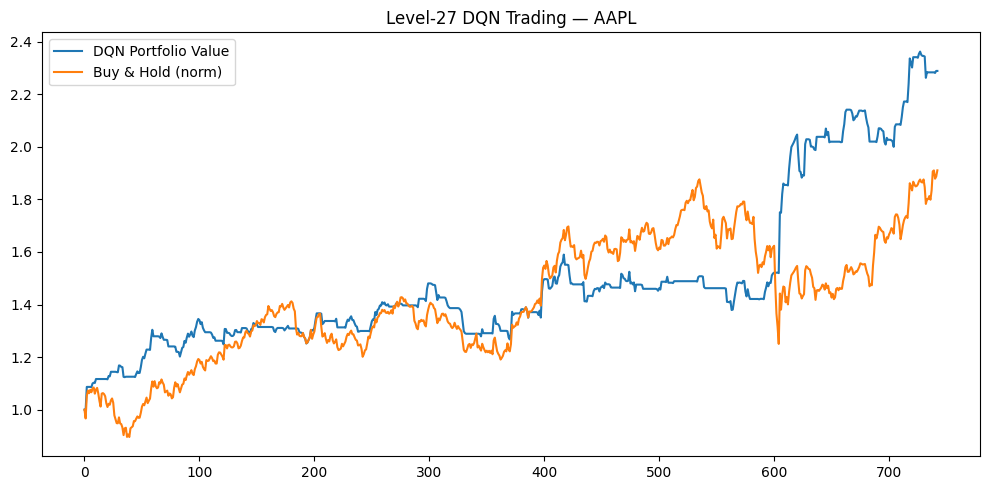

Saved model to C:\Users\adity\Downloads\Learn_DSA_Quant\Level-27


In [2]:
# Level 27 — Deep Q-Learning Trading Agent (fixed shapes, no unused rets, scalar-safe)

import numpy as np, pandas as pd, torch, torch.nn as nn, torch.optim as optim, random, yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Config ----------------
TICKER   = "AAPL"
YEARS    = 3
WINDOW   = 10          # lookback window for state
FEE      = 0.001       # proportional fee (0.1% each trade)
EPISODES = 30
BATCH    = 64
GAMMA    = 0.95
LR       = 1e-3
EPS_DECAY= 0.995
MIN_EPS  = 0.05
REPLAY_MAXLEN = 6000

OUT_DIR  = Path(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-27")
OUT_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- Data ----------------
def load_prices_1d(ticker, years=3) -> np.ndarray:
    df = yf.download(ticker, period=f"{years}y", interval="1d",
                     auto_adjust=True, progress=False)
    if df is None or df.empty:
        return np.array([], dtype=np.float32)
    # Prefer Close, else Adj Close, else last column
    col = None
    if isinstance(df.columns, pd.MultiIndex):
        if "Close" in df.columns.get_level_values(0):
            s = df["Close"]
            # if multiple tickers slipped in, take the first column
            if isinstance(s, pd.DataFrame):
                s = s.iloc[:, 0]
        else:
            # last top-level column fallback
            top = df.columns.get_level_values(0).unique()[-1]
            s = df[top]
            if isinstance(s, pd.DataFrame):
                s = s.iloc[:, 0]
    else:
        if "Close" in df.columns:
            s = df["Close"]
        elif "Adj Close" in df.columns:
            s = df["Adj Close"]
        else:
            # fallback: the last column
            s = df.iloc[:, -1]
    s = s.dropna().astype(float)
    s = s[~s.index.duplicated(keep="last")]
    p = s.to_numpy(dtype=np.float32)
    if p.ndim != 1:
        p = p.reshape(-1)  # force 1-D
    return p

def make_synth(n=800, seed=27) -> np.ndarray:
    rng = np.random.default_rng(seed)
    r = rng.normal(0.0, 0.01, n)
    p = 100.0 * np.exp(np.cumsum(r))
    return p.astype(np.float32)

p = load_prices_1d(TICKER, YEARS)
if p.size == 0:
    print("Using synthetic series (empty download).")
    p = make_synth(800, 27)
    TICKER = "SYNTH"

# Guarantee enough length for WINDOW + training
MIN_LEN = max(WINDOW + 2, 200)
if p.size < MIN_LEN:
    # pad with a synthetic extension that continues last level smoothly
    need = MIN_LEN - p.size
    tail = make_synth(need, 2701)
    tail = tail / tail[0] * p[-1]  # continue from last price level
    p = np.concatenate([p, tail]).astype(np.float32)

print(f"Loaded {p.size} prices for {TICKER}. WINDOW={WINDOW}")

# ---------------- Environment ----------------
class TradingEnv:
    """
    State: [ (window of normalized prices) , position ]
      - window = p[t-W:t] normalized by first window price (w0): (w / w0) - 1
      - position ∈ {0,1}
    Actions: 0=Hold, 1=Buy (if flat), 2=Sell (if long)
    Reward: delta(portfolio_value) = PV_t - PV_{t-1}
    """
    def __init__(self, prices, fee=0.001, window=10):
        self.p = prices.astype(np.float32).reshape(-1)
        self.n = self.p.size
        self.fee = float(fee)
        self.window = int(window)
        self.reset()

    def reset(self):
        self.t = self.window
        self.pos = 0      # 0 flat, 1 long
        self.cash = 1.0   # start with $1
        self.asset = 0.0
        self.prev_port = 1.0
        return self._state()

    def _state(self):
        w = self.p[self.t-self.window:self.t]
        w0 = float(w[0])
        if w0 == 0.0:
            norm = np.zeros_like(w, dtype=np.float32)
        else:
            norm = (w / w0) - 1.0
        return np.concatenate([norm.astype(np.float32), np.array([float(self.pos)], dtype=np.float32)])

    def step(self, action: int):
        price = float(self.p[self.t])
        # Execute action
        if action == 1 and self.pos == 0:  # BUY
            cost = price * (1.0 + self.fee)
            if cost > 0 and self.cash > 0:
                self.asset = self.cash / cost
                self.cash = 0.0
                self.pos = 1
        elif action == 2 and self.pos == 1:  # SELL
            sale = price * (1.0 - self.fee) * self.asset
            self.cash = float(self.cash + sale)
            self.asset = 0.0
            self.pos = 0

        # Advance time
        self.t += 1
        done = self.t >= self.n

        # Compute portfolio & reward (delta PV)
        last_price = float(self.p[self.t-1])
        portfolio = float(self.cash + self.asset * last_price)
        reward = float(portfolio - self.prev_port)
        self.prev_port = portfolio

        next_state = self._state() if not done else np.zeros(self.window + 1, dtype=np.float32)
        return next_state, reward, done, {"portfolio": portfolio}

env = TradingEnv(p, fee=FEE, window=WINDOW)

# ---------------- DQN ----------------
class QNet(nn.Module):
    def __init__(self, dim_state, dim_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_state, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, dim_action)
        )
    def forward(self, x): return self.net(x)

state_dim = WINDOW + 1
n_actions = 3
qnet   = QNet(state_dim, n_actions).to(device)
target = QNet(state_dim, n_actions).to(device)
target.load_state_dict(qnet.state_dict())
opt = optim.Adam(qnet.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# ---------------- Replay Buffer ----------------
from collections import deque
buf = deque(maxlen=REPLAY_MAXLEN)

def sample_batch(batch_size=BATCH):
    batch = random.sample(buf, min(len(buf), batch_size))
    s,a,r,ns,d = map(np.array, zip(*batch))
    S  = torch.tensor(s,  dtype=torch.float32, device=device)
    A  = torch.tensor(a,  dtype=torch.long,    device=device)
    R  = torch.tensor(r,  dtype=torch.float32, device=device)
    NS = torch.tensor(ns, dtype=torch.float32, device=device)
    D  = torch.tensor(d,  dtype=torch.float32, device=device)
    return S,A,R,NS,D

# ---------------- Training ----------------
eps = 1.0
episode_rewards = []

for ep in range(EPISODES):
    s = env.reset()
    total = 0.0
    while True:
        # ε-greedy
        if random.random() < eps:
            a = random.randrange(n_actions)
        else:
            with torch.no_grad():
                qvals = qnet(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0))
                a = int(torch.argmax(qvals).item())

        ns, r, done, info = env.step(a)
        buf.append((s, a, r, ns, done))
        s = ns
        total += r

        # learn
        if len(buf) >= BATCH:
            S,A,R,NS,D = sample_batch()
            with torch.no_grad():
                q_next   = target(NS).max(1)[0]
                q_target = R + GAMMA * (1.0 - D) * q_next
            q_pred = qnet(S).gather(1, A.unsqueeze(1)).squeeze(1)
            loss = loss_fn(q_pred, q_target)
            opt.zero_grad(); loss.backward(); opt.step()

        if done:
            break

    eps = max(MIN_EPS, eps * EPS_DECAY)
    target.load_state_dict(qnet.state_dict())
    episode_rewards.append(total)
    print(f"Episode {ep+1:02d} | Reward {total:.4f} | eps {eps:.3f}")

# ---------------- Evaluation ----------------
s = env.reset()
eq = []
while True:
    with torch.no_grad():
        q = qnet(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0))
        a = int(torch.argmax(q).item())
    ns, r, done, info = env.step(a)
    eq.append(float(info["portfolio"]))
    s = ns
    if done:
        break

eq = np.array(eq, dtype=float)
# Normalize Buy & Hold to start at 1 over the same eval span
bh = p[-len(eq):] / float(p[-len(eq)])

# Plot
plt.figure(figsize=(10,5))
plt.plot(eq, label="DQN Portfolio Value")
plt.plot(bh, label="Buy & Hold (norm)")
plt.title(f"Level-27 DQN Trading — {TICKER}")
plt.legend(); plt.tight_layout(); plt.show()

# Save model
torch.save(qnet.state_dict(), OUT_DIR / f"{TICKER}_dqn.pth")
print(f"Saved model to {OUT_DIR}")
